# Temperature lapse rates

In [1]:
# modules
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_Iceland.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [6]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'forcing_lapse_rates_v2.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Find catchment-average and temperature-lapsed forcing files

In [7]:
# Forcing files as produced by EASYMORE
forcing_easymore_path = read_from_control(controlFolder/controlFile,'forcing_basin_avg_path')

In [8]:
# Specify default path if needed
if forcing_easymore_path == 'default':
    forcing_easymore_path = make_default_path('forcing/3_basin_averaged_data') # outputs a Path()
else:
    forcing_easymore_path = Path(forcing_easymore_path) # make sure a user-specified path is a Path()

In [9]:
# Find the files
_,_,forcing_files_esmr = next(os.walk(forcing_easymore_path))
forcing_files_esmr.sort()

In [10]:
# Location for SUMMA-ready files
forcing_summa_path = read_from_control(controlFolder/controlFile,'forcing_summa_path')

In [11]:
# Specify default path if needed
if forcing_summa_path == 'default':
    forcing_summa_path = make_default_path('forcing/4_SUMMA_input') # outputs a Path()
else:
    forcing_summa_path = Path(forcing_summa_path) # make sure a user-specified path is a Path()

In [12]:
# Find the files
_,_,forcing_files_summa = next(os.walk(forcing_summa_path))
forcing_files_summa.sort()

#### Find where the catchment/forcing intersection is

In [13]:
# Intersected shapefile path. Name is set by EASYMORE as [prefix]_intersected_shapefile.shp
intersect_path = read_from_control(controlFolder/controlFile,'intersect_forcing_path')

In [14]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [15]:
# Make the file name
domain = read_from_control(controlFolder/controlFile,'domain_name')
intersect_name = domain + '_intersected_shapefile.csv' # can also be .shp, but using the .csv is easier on memory

#### Find where the catchment/DEM intersection is

In [16]:
# Find location of DEM intersection for shapes and elevation
elev_catchment_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
elev_catchment_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

In [17]:
# Specify default path if needed
if elev_catchment_path == 'default':
    elev_catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    elev_catchment_path = Path(elev_catchment_path) # make sure a user-specified path is a Path()

#### Find where the ERA5 geopotential data is

In [18]:
# Find file path
geo_path = read_from_control(controlFolder/controlFile,'forcing_geo_path')

In [19]:
# Specify the default path if required
if geo_path == 'default':
    geo_path = make_default_path('forcing/0_geopotential')
else: 
    geo_path = Path(geo_path) # ensure Path() object 

In [20]:
# Specify the filename
geo_name = 'ERA5_geopotential.nc'

#### Reproduce the lapse code

In [30]:
# Load the intersection file
topo_data = pd.read_csv(intersect_path/intersect_name) 

In [31]:
# Find hruId name in user's shapefile
hru_ID_name = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')
gru_ID_name = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')

In [32]:
# Specify the column names
# Note that column names are truncated at 10 characters in the ESRI shapefile, but NOT in the .csv we use here
gru_ID         = 'S_1_' + gru_ID_name # EASYMORE prefix + user's hruId name
hru_ID         = 'S_1_' + hru_ID_name # EASYMORE prefix + user's hruId name
forcing_ID     = 'S_2_ID'             # fixed name assigned by EASYMORE
catchment_elev = 'S_1_elev_mean'      # EASYMORE prefix + name used in catchment+DEM intersection step
forcing_elev   = 'S_2_elev_m'         # EASYMORE prefix + name used in ERA5 shapefile generation
weights        = 'weight'             # EASYMORE feature

In [33]:
# Define the lapse rate
lapse_rate = 0.0065 # [K m-1]

In [86]:
# Calculate weighted lapse values for each HRU 
# Note that these lapse values need to be ADDED to ERA5 temperature data
topo_data['lapse_values'] = topo_data[weights] * lapse_rate * \
    (topo_data[forcing_elev] - topo_data[catchment_elev]) # [K]

In [87]:
# Find the total lapse value per basin; i.e. sum the individual contributions of each HRU+ERA5-grid overlapping part
lapse_values = topo_data.groupby([hru_ID]).lapse_values.sum()
lapse_values.index = lapse_values.index.rename('fid')
lapse_values['fid'] = lapse_values.index.values
#lapse_values = topo_data.groupby([hru_ID]).lapse_values.sum()#.reset_index()
print(lapse_values)

fid
7.0                                                -0.039433
8.0                                                -1.082094
9.0                                                -1.294675
10.0                                                -0.84465
11.0                                               -0.443292
                                 ...                        
10892.0                                             1.063564
10893.0                                             1.017316
10894.0                                             1.520139
10895.0                                             1.507986
fid        [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ...
Name: lapse_values, Length: 10865, dtype: object


In [82]:
# Sort and set hruID as the index variable
lapse_values = lapse_values.sort_values(hru_ID).set_index(hru_ID)

TypeError: Series.sort_values() takes 1 positional argument but 2 were given

In [28]:
# Close the main file
del topo_data # hopefully this saves some RAM but this is apparently not so straightforward in Python.. Can't hurt

#### Prepare plotting data (elevation, lapse rates)

In [37]:
# load catchment with DEM
catchment = gpd.read_file(elev_catchment_path/elev_catchment_name)

In [38]:
# Create a shapefile with only GRU boundaries for overlay
hm_grus_only = catchment[[gru_ID_name,'geometry']] # keep only the gruId and geometry
hm_grus_only = hm_grus_only.dissolve(by=gru_ID_name) # Dissolve HRU delineation

In [135]:
# Add lapse rates to catchment shapefile
#catchment['fid'] = catchment.index.values
#catchment = catchment.set_index(hru_ID_name) # ensure that HRU_ID is the index

catchment['lapse_rate'] = lapse_values.values[:-1] # merge with the lapse rate dataframe
catchment


,streamID,center_lat,center_lon,HRU_area,elev_mean,geometry,lapse_rate,old_T,new_T
fid,,,,,,,,,
7.0,94.0,66.491313,-16.475102,4.759548e+06,11.868185,"POLYGON ((-16.47462 66.51449, -16.47439 66.514...",-0.039433,273.369019,271.231153
8.0,95.0,66.425602,-22.934435,5.171903e+06,208.372392,"POLYGON ((-22.91911 66.44294, -22.91887 66.442...",-1.082094,271.990417,270.005822
9.0,96.0,66.415716,-22.996603,6.917460e+06,241.077082,"POLYGON ((-22.99918 66.43071, -22.99872 66.430...",-1.294675,272.454651,270.897735
10.0,97.0,66.342840,-23.023239,5.849050e+06,258.830053,"POLYGON ((-23.00289 66.35260, -23.00173 66.352...",-0.84465,272.910004,271.161233
11.0,98.0,66.322681,-23.044861,1.158526e+07,197.082664,"POLYGON ((-23.07577 66.34305, -23.07508 66.343...",-0.443292,272.688660,270.689139
...,...,...,...,...,...,...,...,...,...
10891.0,48128.0,64.797742,-15.868487,8.052737e+05,570.937512,"POLYGON ((-15.86907 64.80838, -15.86861 64.808...",1.639346,NaN,NaN
10892.0,48288.0,64.831846,-15.929088,1.874350e+07,659.141881,"POLYGON ((-15.90342 64.86916, -15.90296 64.869...",1.063564,NaN,NaN
10893.0,48448.0,64.789998,-20.732402,6.416776e+06,372.141666,"POLYGON ((-20.68538 64.80738, -20.68514 64.807...",1.017316,NaN,NaN


#### Prepare plotting data (geopotential -> ERA5 elevation)

In [99]:
# Open the geopotential data file
geo = xr.open_dataset( geo_path / geo_name ).isel(time=0)

In [100]:
# Define the gravitational acceleration constant
g = 9.80665 # [m s-2]

In [101]:
# Make a new variable
geo['elev'] = geo['z'] / g

#### Prep plotting data (old and new forcing)

In [111]:
# select the files
idx = 0
old_file = forcing_files_esmr[idx+1]
new_file = forcing_files_summa[idx]

In [113]:
old_file
new_file

'Iceland_remapped_2000-01-01-00-00-00.nc'

In [114]:
# open old and new file
forcing_old = xr.open_dataset(forcing_easymore_path / old_file)
forcing_new = xr.open_dataset(forcing_summa_path / new_file)

In [115]:
# Prepare dataframes with temperature for a given time
time = 0
old_temp = {'airtemp': forcing_old['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}
new_temp = {'airtemp': forcing_new['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}

In [123]:
# Make dataframes
df_old_temp = pd.DataFrame(old_temp)
df_new_temp = pd.DataFrame(new_temp)


<xarray.Dataset> Size: 259MB
Dimensions:    (time: 744, hru: 10864)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:00:00
Dimensions without coordinates: hru
Data variables:
    latitude   (hru) float64 87kB ...
    longitude  (hru) float64 87kB ...
    hruId      (hru) float64 87kB ...
    airpres    (time, hru) float32 32MB ...
    LWRadAtm   (time, hru) float32 32MB ...
    SWRadAtm   (time, hru) float32 32MB ...
    pptrate    (time, hru) float32 32MB ...
    airtemp    (time, hru) float64 65MB ...
    spechum    (time, hru) float32 32MB ...
    windspd    (time, hru) float32 32MB ...
    data_step  int64 8B ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by SUMMA public workflow scripts
    License:      Copernicus data use license: https://cds.climate.copernicus...
    History:      Created Sun Mar 24 19:00:36 2024
    Source:       Case: Iceland; remapped by script from library of Shervan G...


In [117]:
# Set indices
df_old_temp = df_old_temp.set_index('hruId')
df_new_temp = df_new_temp.set_index('hruId')

In [136]:
# Merge with catchment shapefile
catchment['old_T'] = df_old_temp['airtemp']
catchment['new_T'] = df_new_temp['airtemp']
print(catchment)
catchment.to_file(elev_catchment_path/elev_catchment_name, driver='ESRI Shapefile')

         streamID  center_lat  center_lon      HRU_area   elev_mean  \
fid                                                                   
7.0          94.0   66.491313  -16.475102  4.759548e+06   11.868185   
8.0          95.0   66.425602  -22.934435  5.171903e+06  208.372392   
9.0          96.0   66.415716  -22.996603  6.917460e+06  241.077082   
10.0         97.0   66.342840  -23.023239  5.849050e+06  258.830053   
11.0         98.0   66.322681  -23.044861  1.158526e+07  197.082664   
...           ...         ...         ...           ...         ...   
10891.0   48128.0   64.797742  -15.868487  8.052737e+05  570.937512   
10892.0   48288.0   64.831846  -15.929088  1.874350e+07  659.141881   
10893.0   48448.0   64.789998  -20.732402  6.416776e+06  372.141666   
10894.0   48608.0   64.808267  -15.866003  5.016419e+04  589.292326   
10895.0   48768.0   64.822959  -15.860940  3.078879e+06  591.162018   

                                                  geometry lapse_rate  \
fid

#### Figure

In [119]:
# plot settings
cmap_elev = 'terrain'
cmap_lapse = 'coolwarm'

In [120]:
# scaling
vmin_elev,vmax_elev = catchment['elev_mean'].min(),catchment['elev_mean'].max()
vmin_rate,vmax_rate = -5,5
vmin_temp = min(df_new_temp.min().values,df_old_temp.min().values)
vmax_temp = max(df_new_temp.max().values,df_old_temp.max().values)
#vmin_temp,vmax_temp = 252,262 # these ranges match those in the grid-to-hru figure

In [121]:
# Get the forcing time
time_str_old = forcing_old['time'].isel(time=time).dt.strftime('%Y-%m-%d %H:%M').values
time_str_new = forcing_new['time'].isel(time=time).dt.strftime('%Y-%m-%d %H:%M').values

AttributeError: 'Axes' object has no attribute 'flatten'

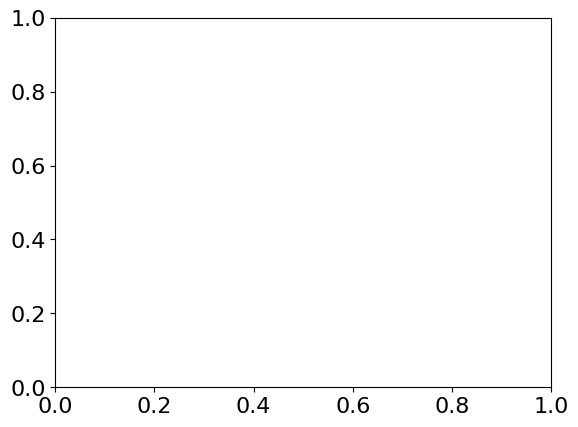

In [129]:
# figure
fig, axs = plt.subplots(2,2,figsize=(20,20))
axs = axs.flatten()
plt.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 16}) 

# --- elevation
axId = 0

# Data
geo['elev'].plot(ax=axs[axId], cmap = cmap_elev, add_colorbar=False, vmin=vmin_elev, vmax=vmax_elev)
catchment.plot(ax=axs[axId], column='elev_mean',edgecolor='k', cmap = cmap_elev, legend=False, vmin=vmin_elev, vmax=vmax_elev)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.55, 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap_elev, norm=plt.Normalize(vmin=vmin_elev, vmax=vmax_elev))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.set_title('  [m.a.s.l.]')


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) ERA5 grid and mean HRU elevation');
axs[axId].set_frame_on(False)
axs[axId].set_ylabel('Latitude [degrees North]');


# --- lapse rates
axId = 1

# Data
catchment.plot(ax=axs[axId], column='lapse_rate',edgecolor='k', cmap = cmap_lapse, legend=False, vmin=-5, vmax=5)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.55, 0.02, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap_lapse, norm=plt.Normalize(vmin=vmin_rate, vmax=vmax_rate))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.set_title('[K]')


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(b) Temperature lapse rates');
axs[axId].set_frame_on(False)


# --- reset axes on first plot
xlim = axs[axId].get_xlim()
ylim = axs[axId].get_ylim()
axId = 0
axs[axId].set_xlim(xlim)
axs[axId].set_ylim(ylim)

# ---------------------------------------------------------------------------------------------------------------
# --- old forcing
axId = 2

# Data
catchment.plot(ax=axs[axId], column='old_T',edgecolor='k', legend=False, vmin=vmin_temp, vmax=vmax_temp)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.05, 0.02, 0.4])
vmin = min(df_new_temp.min().values,df_old_temp.min().values)
vmax = max(df_new_temp.max().values,df_old_temp.max().values)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_temp, vmax=vmax_temp))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.set_title('[K]')

# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(c) HRU-averaged temperature on {}'.format(time_str_old))
axs[axId].set_frame_on(False)
axs[axId].set_xlabel('Longitude [degrees East]');
axs[axId].set_ylabel('Latitude [degrees North]');


# --- new forcing
axId = 3

# Data
catchment.plot(ax=axs[axId], column='new_T',edgecolor='k', legend=False, vmin=vmin_temp, vmax=vmax_temp)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.05, 0.02, 0.4])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_temp, vmax=vmax_temp))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.set_title('[K]')

# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(d) HRU-averaged temperature with lapse rates on {}'.format(time_str_new))
axs[axId].set_frame_on(False)
axs[axId].set_xlabel('Longitude [degrees East]');


# save
plt.tight_layout()
plt.savefig(fig_path/fig_name, bbox_inches='tight', dpi=300)